# Gerando polígonos de vias no município de São Paulo

A intenção desse notebook é demonstrar e fomentar técnicas de trabalho de geoprocessamento com linguaem de programação, tentando obter um polígono de vias do município de São Paulo utilizando as seguintes camadas do [Geosampa](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/_SBC.aspx) 

* [Logradouros](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadCamadas&arq=05_Sistema%20Vi%E1rio%5C%5CLogradouro%5C%5CShapefile%5C%5CSIRGAS_SHP_logradouronbl&arqTipo=Shapefile)
* [Quadras Viárias](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadCamadas&arq=11_Cadastro%5C%5CQuadra%5C%5CShapefile%5C%5CSIRGAS_SHP_quadraMDSF&arqTipo=Shapefile)

Para nossos primeiros experimentos vamos recortar ambas as camadas pela folha número 3316-221 do _SCM_ (Sistema Cartográfico Municipal). Esses arquivos processados estão na pasta gis desse projeto. 

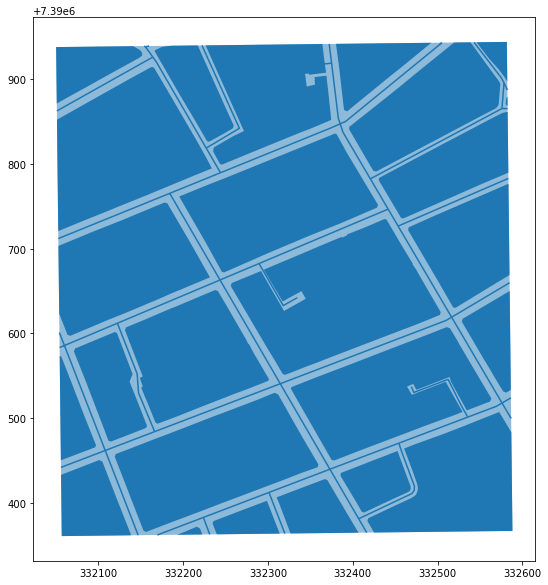

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (20, 10)


df_scm = gpd.read_file('./gis/scm-3316-221.geojson')
df_quadras = gpd.read_file('./gis/quadras-3316-221.geojson')
df_logradouros = gpd.read_file('./gis/logradouros-3316-221.geojson')

f, ax = plt.subplots(1)
df_scm.plot(ax=ax, alpha=0.5)
df_quadras.plot(ax=ax)
df_logradouros.plot(ax=ax)

plt.show()



## Importando shapefiles para o Postgis

Inicialmente optamos por trabalhar com os dados georeferenciados dentro do banco de dados PostGis. Para isso é necessário importar os Shapefiles para dentro do banco. Neste post é possível aprender [3 maneiras de importar ShapeFiles para dentro do banco de dados PostGis](http://www.clickgeo.com.br/formas-de-importar-shapes-postgis/)



## Trabalhando com o banco de dados PostGis

A primeira estratégia a ser testada vai ser de criar uma geometria única com as ruas que será resultante da intersecção do poígono da SCM total com as quadras. Depois de obtido esse polígono então vamos utilizar o [ST_ApproximateMedialAxis](https://postgis.net/docs/ST_ApproximateMedialAxis.html) para traçar uma rede central e a partir dai tentar dividir o polígono total baseado nos nós de interesecção.

In [2]:
from sqlalchemy import create_engine
from env import *

engine = create_engine("postgresql+psycopg2://%s:%s@%s:%s/%s"%(user, password, host, port, database))
print (engine.table_names())

['quadras', 'scm', 'sqls_tita', 'scm_1_5000', 'logradouros', 'vias']


### Criando os dataframes pelo Banco de Dados

In [3]:
df_scm = gpd.GeoDataFrame.from_postgis(sql="SELECT * from public.scm;", con=engine)
df_quadras = gpd.GeoDataFrame.from_postgis(sql="SELECT * from public.quadras;", con=engine)

### Gerando as diferenças entre as feições do SCM com a quadra

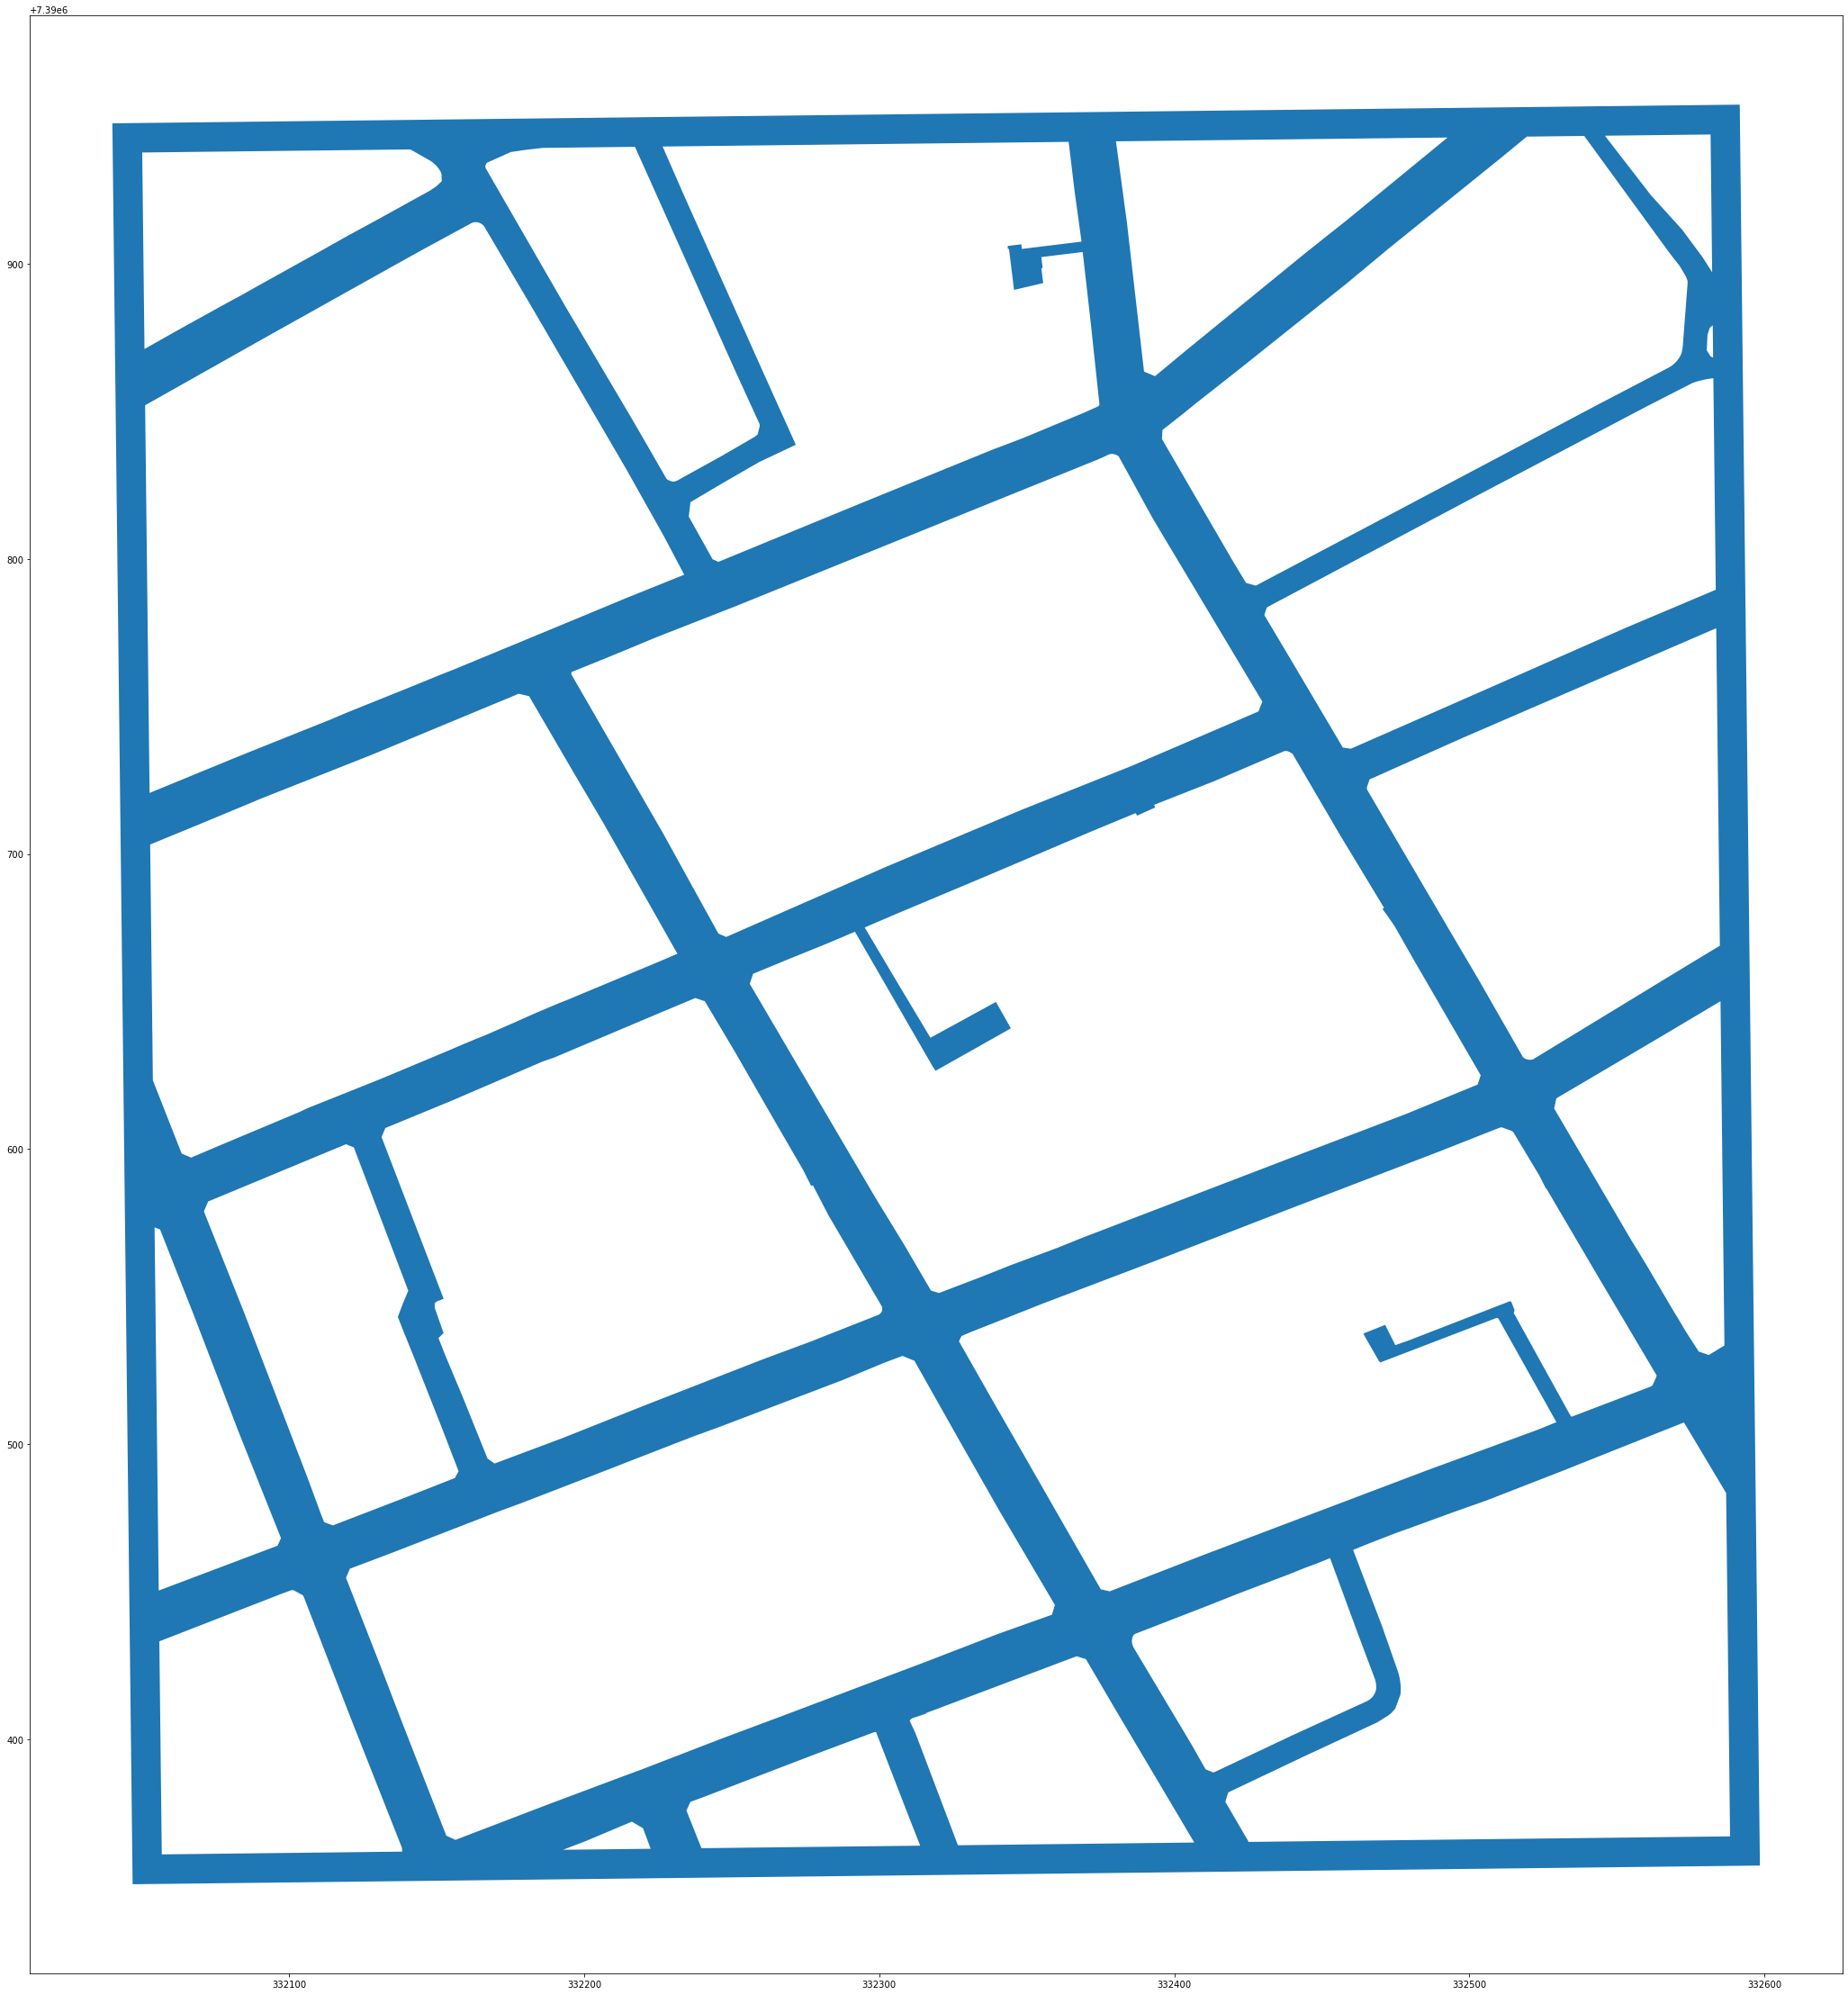

In [4]:
df_vias = gpd.overlay(df_scm, df_quadras, how='difference')
plt.rcParams['figure.figsize'] = (40, 40)
df_vias.plot()

### Persistindo a geometria na base de dados

In [5]:
from geoalchemy2 import Geometry, WKTElement

# df_vias['geom'] = df_vias['geom'].apply(lambda x: WKTElement(x.wkt, srid=31983))
# df_vias.to_sql('vias', con=engine, schema='public', if_exists='replace', index=False, dtype={'geom': Geometry('POLYGON', srid=31983)})

# Instanciando vias novamente 
# df_vias = gpd.GeoDataFrame.from_postgis(sql="select * from vias;", con=engine)

In [6]:
# Esse comando não se monstrou eficiante, além de muito lento
#df_medial_axis = gpd.GeoDataFrame.from_postgis(sql="SELECT ST_ApproximateMedialAxis(ST_MakeValid(geom)) as geom from public.vias;", con=engine)

## Definindo uma nova estratégia

Como o MedialAxis não funcionou com uma quantidade essa quantidade de rings no polígono provavelmente vamos ter que descarta-lo e utilizar as próprias linhas do traçado do viário para recortar esse polígono

### capturando os pontos iniciais de conexão de logradouros

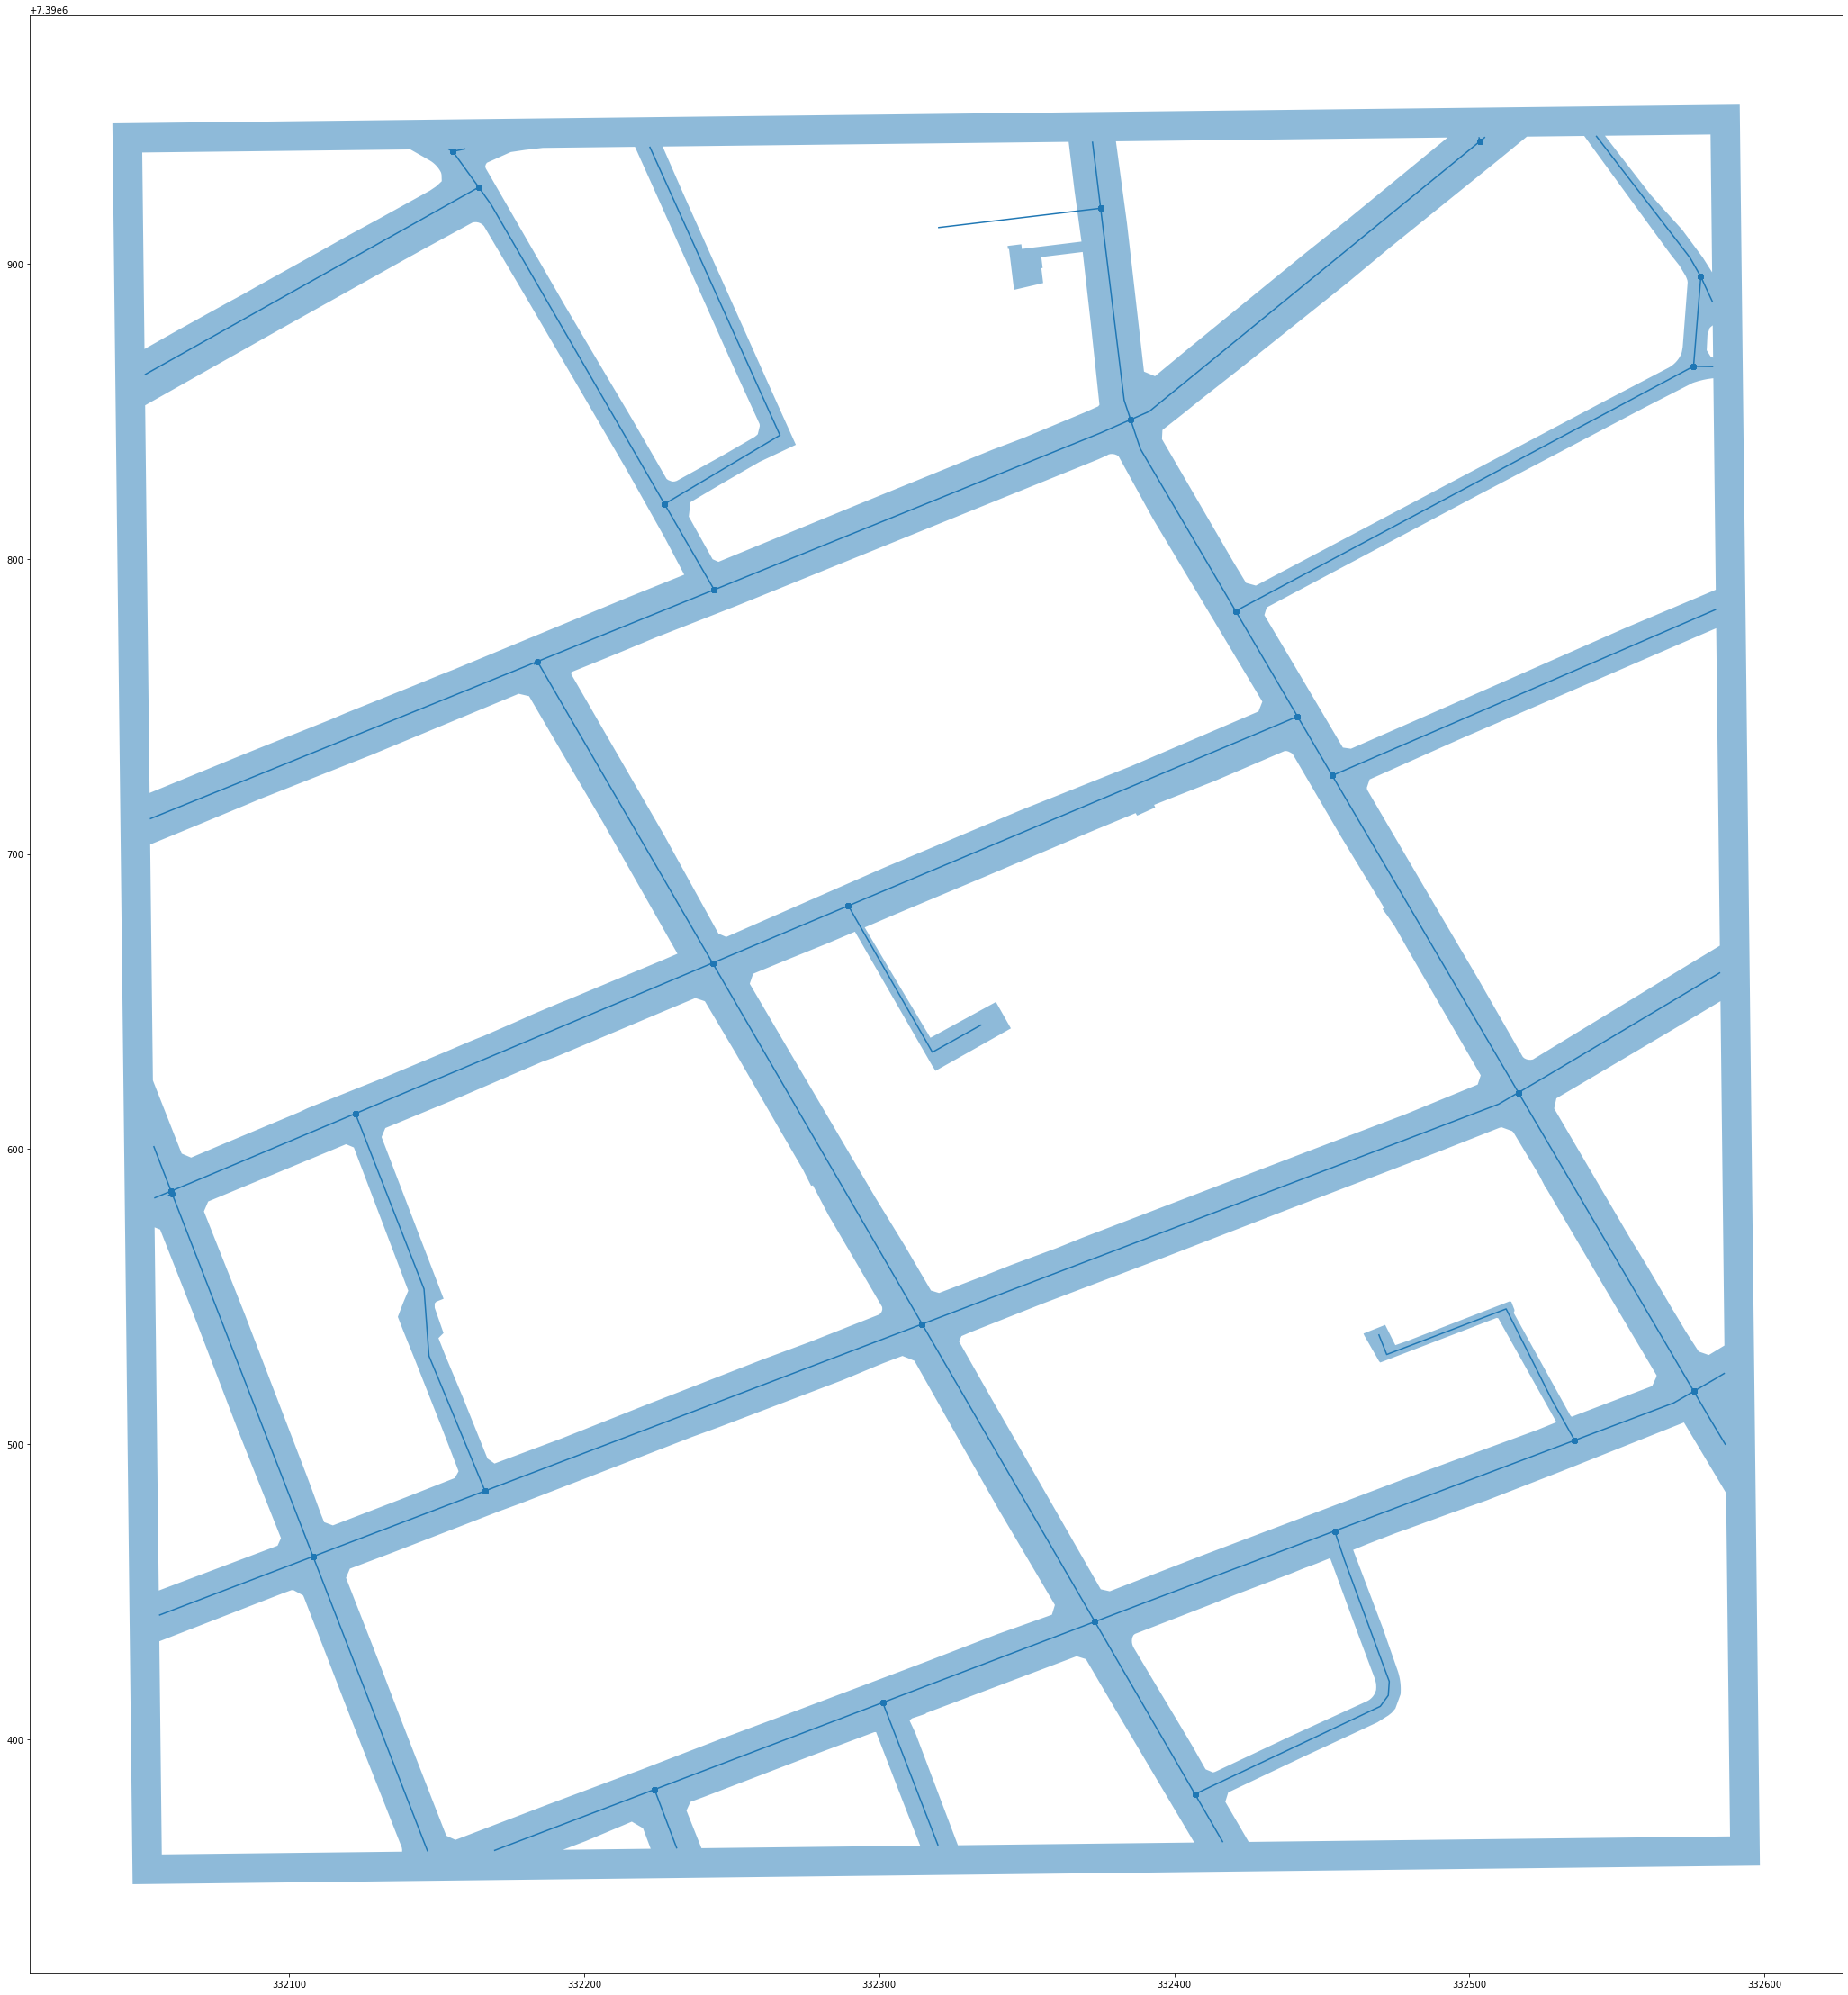

In [7]:
sql_cruzamentos = """ 

select st_intersection(a.geom, b.geom) as geom 
from logradouros as a, logradouros as b 
where st_touches(a.geom, b.geom); """

df_cruzamentos = gpd.GeoDataFrame.from_postgis(sql=sql_cruzamentos, con=engine)

f, ax = plt.subplots(1)
df_vias.plot(ax=ax, alpha=0.5)
df_cruzamentos.plot(ax=ax)
df_logradouros.plot(ax=ax)

plt.show()

Como alguns pontos acabam ficando muito próximos, seria interessante agregar todos os pontos do cruzamento.

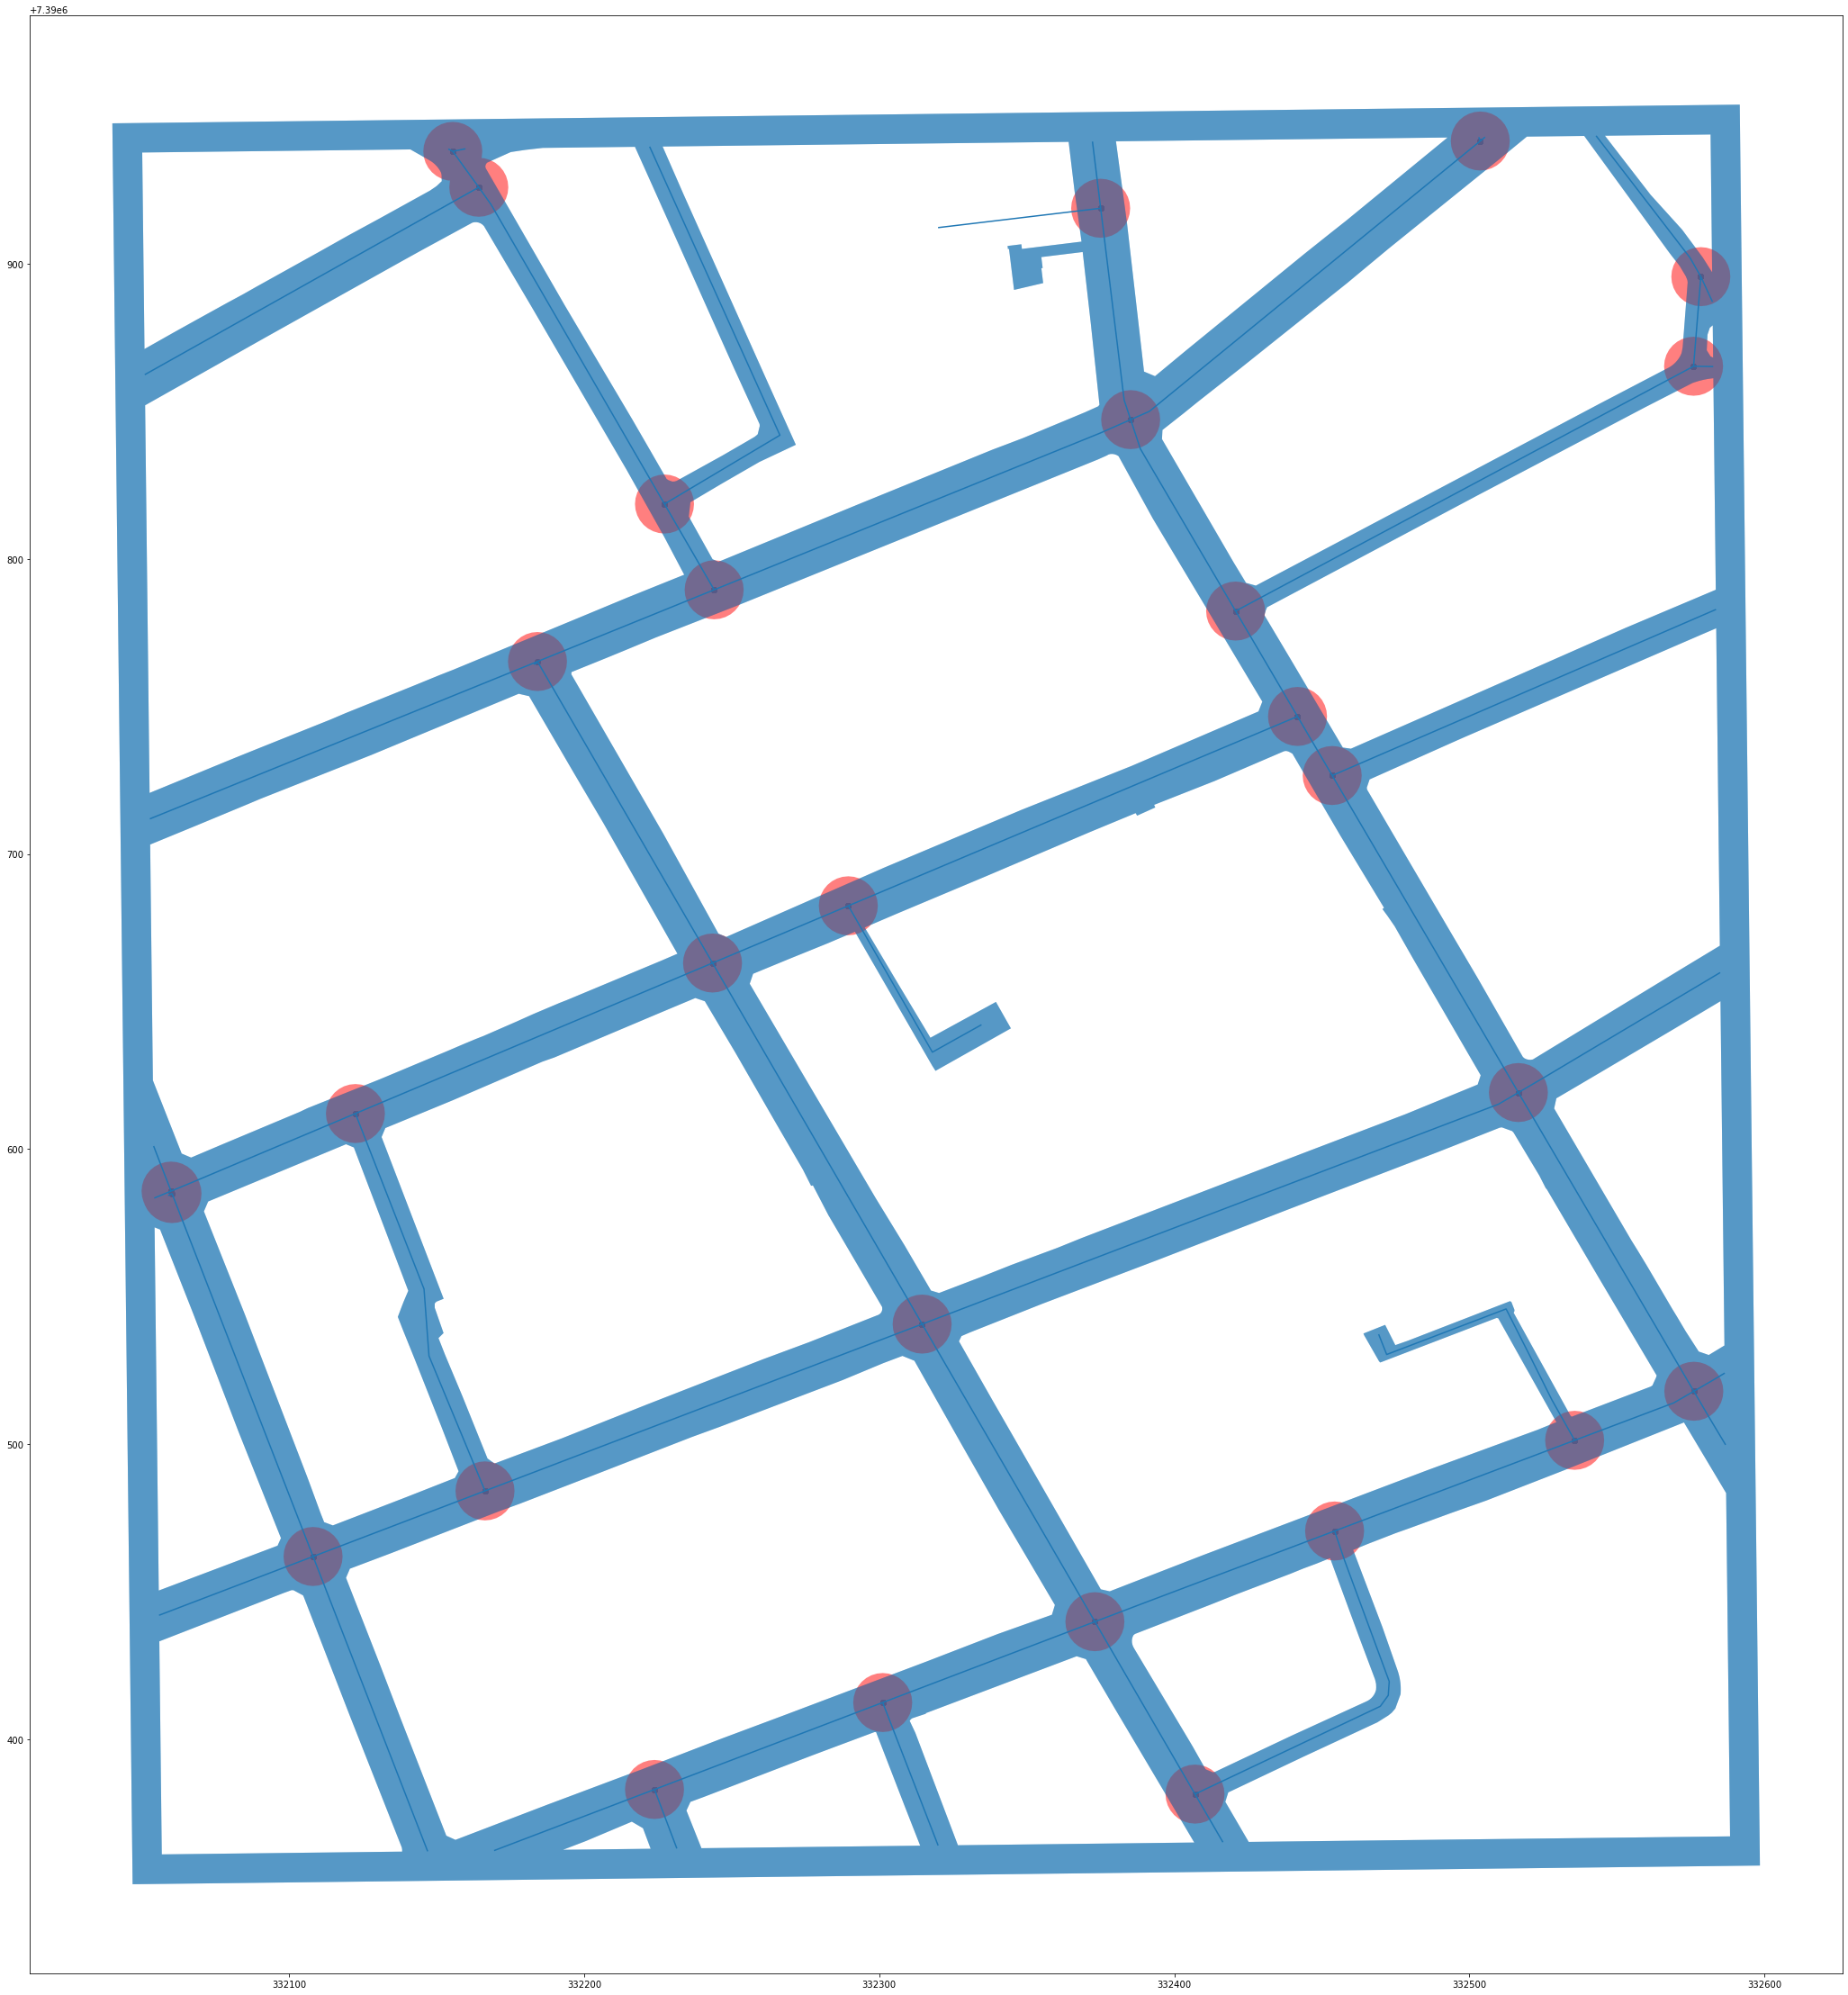

In [8]:
sql_cruz_buffer =  """

select (st_dump(geom)).geom as geom from 
(select st_union(st_buffer(st_intersection(a.geom, b.geom), 10)) as geom 
from logradouros as a, logradouros as b 
where st_touches(a.geom, b.geom)) as sub_query """

df_cruz_buffer = gpd.GeoDataFrame.from_postgis(sql=sql_cruz_buffer, con=engine)

f, ax = plt.subplots(1)
df_vias.plot(ax=ax, alpha=0.5)
df_cruzamentos.plot(ax=ax)
df_logradouros.plot(ax=ax)
df_cruz_buffer.plot(ax=ax, alpha=0.5, color='red')
df_vias.plot(ax=ax, alpha=0.5)

plt.show()

## Criando linhas para 'cortar' os polígonos

Agora que temos que cortar o polígono precisamos de linhas para realizar esse fatiamento. 
Primeiramente vamos criar uma intersecção dos buffers dos nós com o traçado dos logradouros

In [13]:
#df_pontos_via = df_cruz_buffer['geometry'].intersection(df_logradouros['geometry'])
from shapely.geometry import Polygon, Point, MultiPoint, LineString

#def cria_poligono(linearring):
#    return linearring.envelope

df_pontos_via = df_logradouros['geometry'].intersection(df_cruz_buffer.geom.exterior)

#df_cruz_buffer['geom'] = df_cruz_buffer['geom'].apply(cria_poligono)

#seila = gpd.GeoSeries.intersection(df_cruz_buffer.geom.boundary, df_logradouros.geometry )
df_logradouros.touches(df_cruz_buffer)
df_buffer_index = df_cruz_buffer.sindex

seila = df_logradouros['geometry'].intersection(df_logradouros['geometry'])
novo = df_cruz_buffer['geom'].intersection(seila)
print(df_logradouros.crs)
print(df_cruz_buffer.crs)



{'init': 'epsg:31983'}
{'init': 'epsg:31983'}


Testando a intersecção pelo Geopandas com um pequeno exemplo

In [55]:
%%time

from shapely.ops import split
from math import atan2, degrees
from shapely.affinity import rotate

# criando um polígono de cruzamento hipotético
poligono =  Point((0,0)).buffer(1)
df_poligono = gpd.GeoDataFrame([0], geometry=[poligono])

# criando linhas de traçado viário hipotéticas
linha1 = LineString([Point(0, 0), Point(2, 2)])
linha2 = LineString([Point(0, 0), Point(-1, 2)])
linha3 = LineString([Point(-0.1, -0.1), Point(1, -2)])
df_linha = gpd.GeoDataFrame([0, 1, 2], geometry=[linha1, linha2, linha3])

inter_poligono_linha = df_linha.unary_union.intersection(df_poligono.unary_union)
df_inter_poligono_linha = gpd.GeoDataFrame([0], geometry=[inter_poligono_linha])

inter_ponto_borda = df_poligono.boundary.intersection(df_linha.unary_union)
df_inter_ponto_borda = gpd.GeoDataFrame([0], geometry=inter_ponto_borda)
cx, cy = df_poligono.geometry.centroid.x, df_poligono.geometry.centroid.y
angulos = [degrees(atan2(point.y - cy, point.x - cx)) for point in inter_ponto_borda[0]]
print(angulos)


nova_linha = [LineString([Point(0,0), point]) for point in inter_ponto_borda[0]]
df_nova_linha = gpd.GeoDataFrame(list(range(len(nova_linha))), geometry=nova_linha)
df_nova_linha.columns = ['index', 'geometry']
df_nova_linha['geometry'] = df_nova_linha['geometry'].scale(xfact=1.5, yfact=1.5, origin=(0,0))


#rotacionar o poligono para que o ponto inicial coincida com algum segmento
#TODO
poligono = rotate(poligono, angulos[0], origin=(cx, cy))

fatiado = split(poligono.boundary, df_nova_linha.unary_union)
fatias = [fatia for fatia in fatiado]
df_fatiado = gpd.GeoDataFrame(list(range(len(fatias))), geometry=fatias)
df_fatiado.columns = ['index', 'geometry']


ponto_medio = [fatia.interpolate(0.5, normalized=True) for fatia in fatiado]
df_ponto_medio = gpd.GeoDataFrame(list(range(len(ponto_medio))), geometry=ponto_medio)
df_ponto_medio.columns = ['index', 'geometry']


[116.56505117707799, -67.78708909885995, 45.0]
Wall time: 0 ns


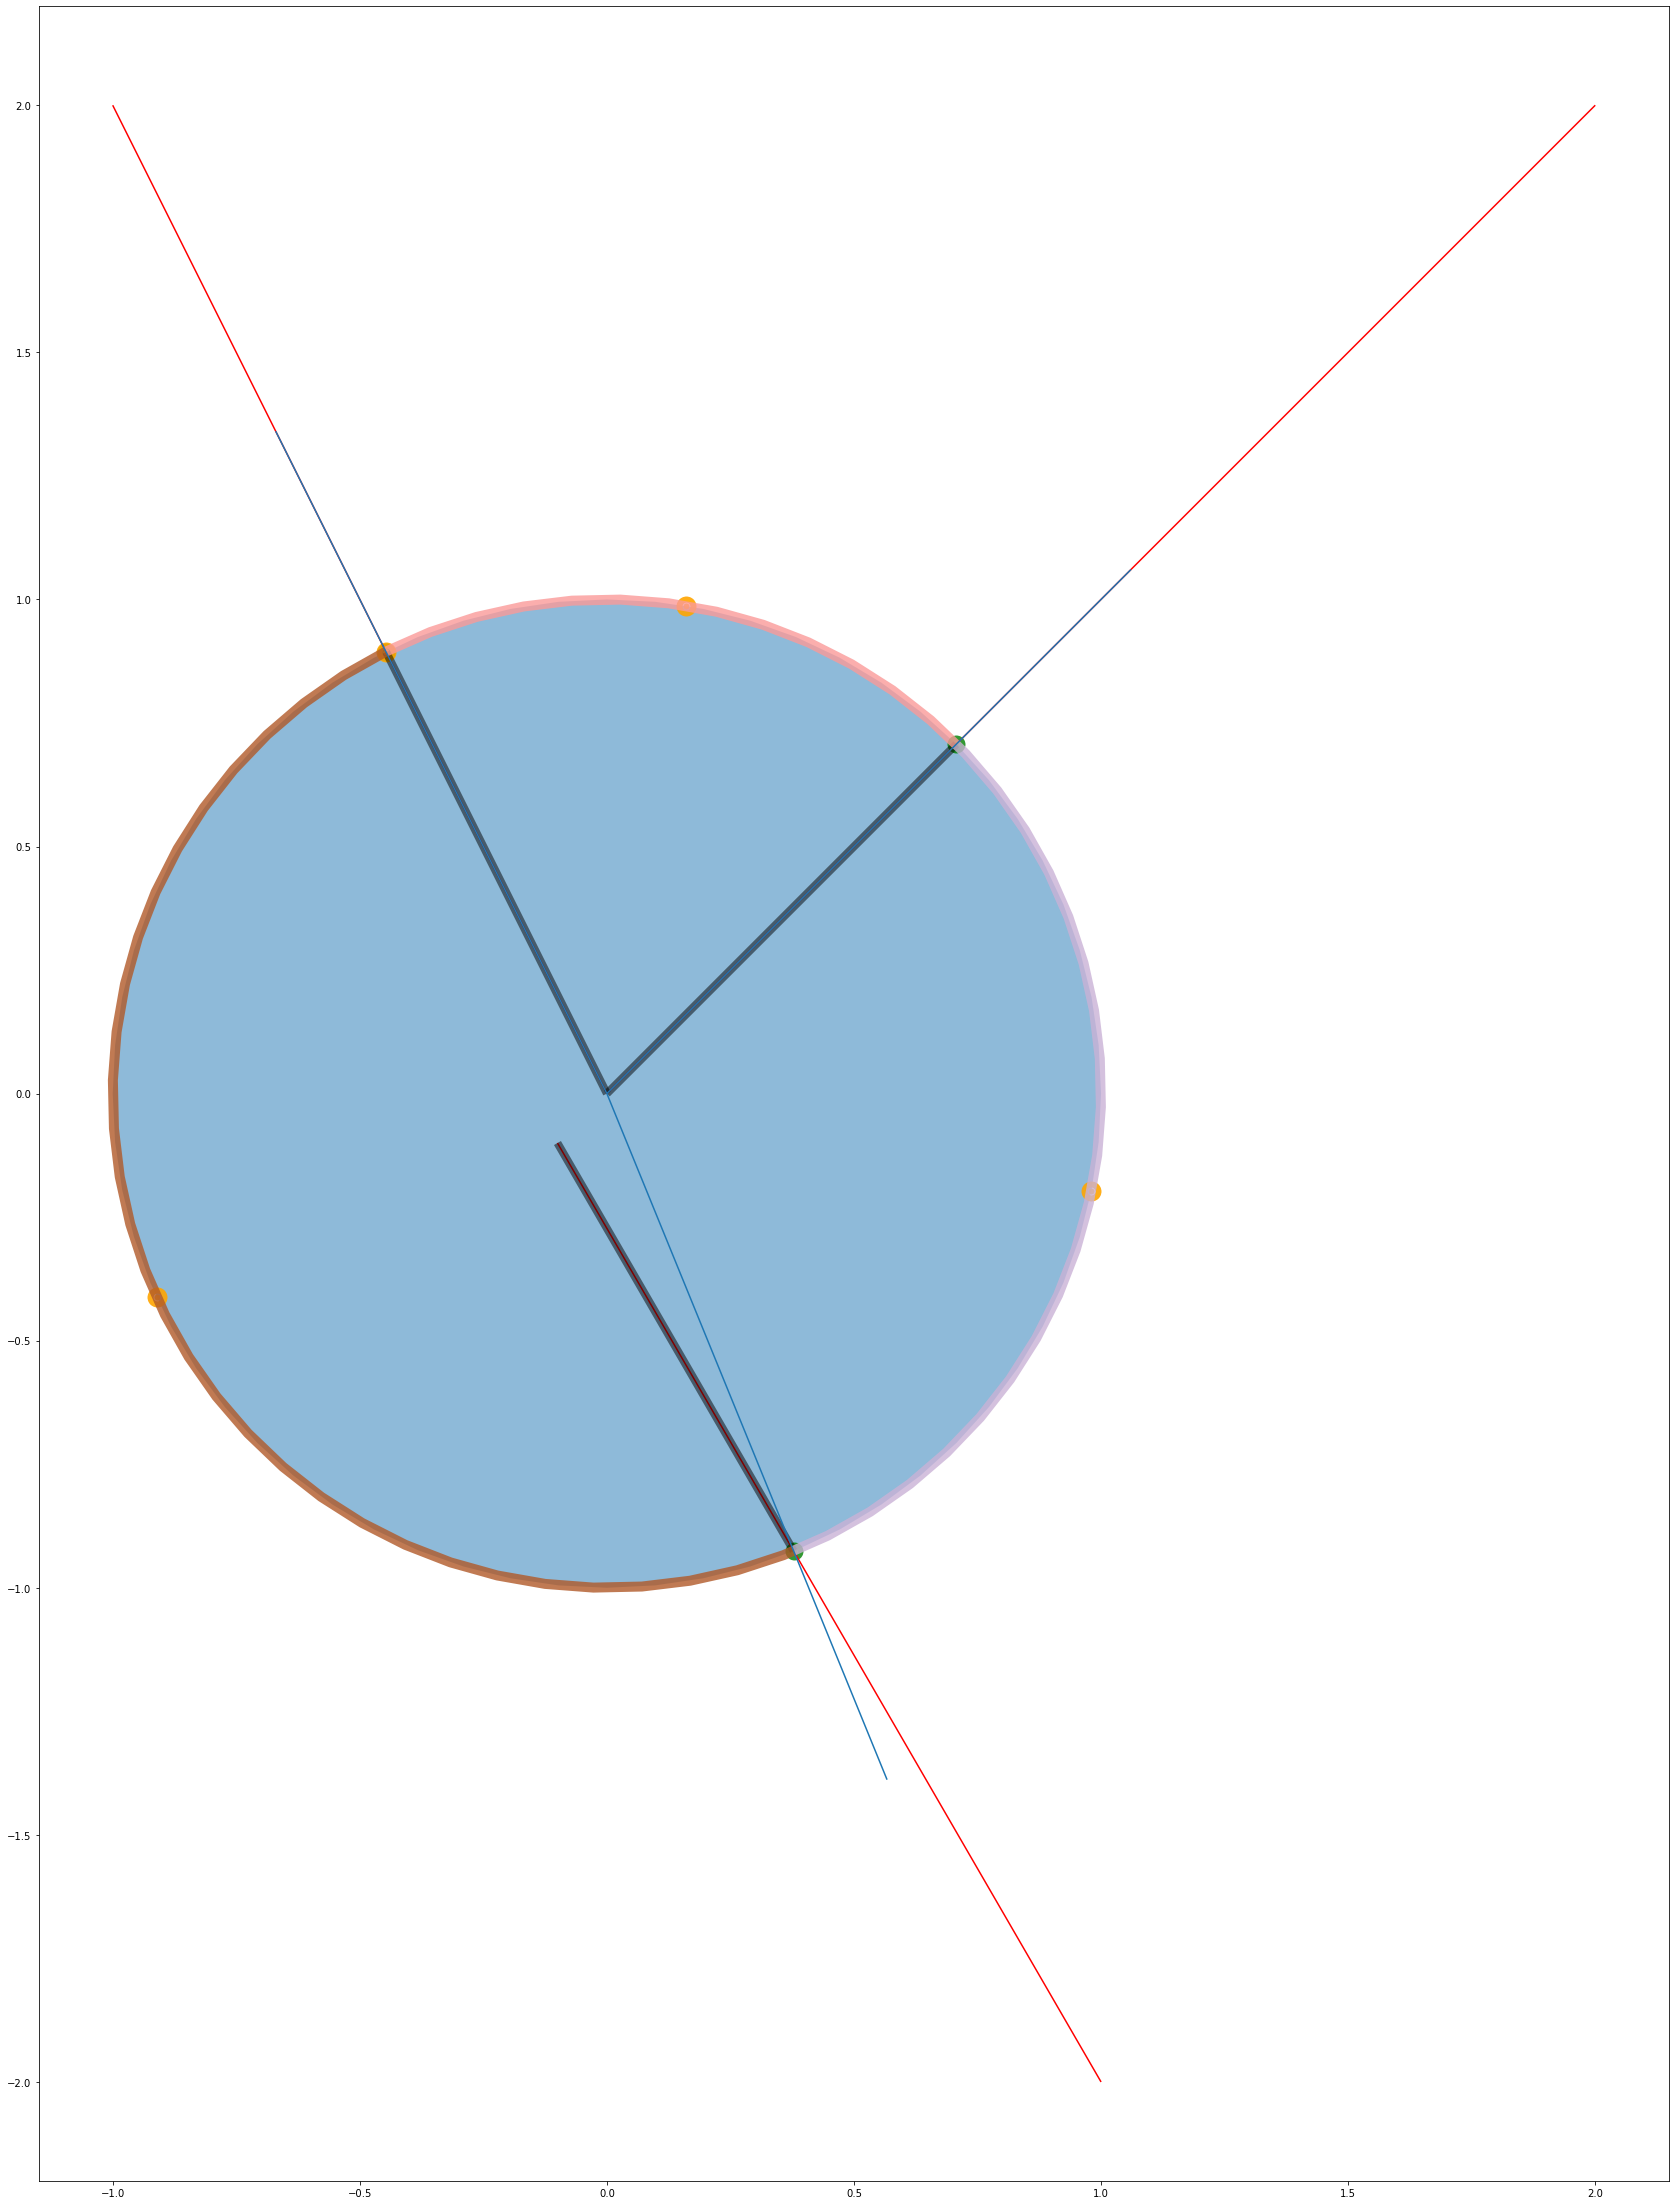

In [56]:
f, ax = plt.subplots(1)

df_poligono.plot(ax=ax, alpha=0.5)
df_linha.plot(ax=ax, color='red')
df_inter_poligono_linha.plot(ax=ax, color='black', alpha=0.5, linewidth=8)
df_inter_ponto_borda.plot(ax=ax, color='green', alpha=0.8, linewidth=12)
df_fatiado.plot(ax=ax, column='index', lw=3, cmap='Paired', alpha=0.8, linewidth=10)
df_nova_linha.plot(ax=ax)
df_ponto_medio.plot(ax=ax, color='orange', alpha=0.9, linewidth=14)

plt.show()

In [ ]:
f, ax = plt.subplots(1)

# Aplicando o zoom
plt.margins(x=-0.30, y=-0.40)

df_vias.plot(ax=ax, alpha=0.5)
df_cruzamentos.plot(ax=ax)
df_logradouros.plot(ax=ax)
df_cruz_buffer.plot(ax=ax, alpha=0.5, color='red')
df_vias.plot(ax=ax, alpha=0.5)
df_pontos_via.plot(ax=ax)

plt.show()